<center>
    <h1> Proyecto #3 - Treecode con armónicos esféricos </h1>
    <h4 style="margin:10px;"> IPM-407 - Modelación Computacional con Algoritmos Rápidos </h4>
    <h3> Hernán Vargas -- 201073009-3 </h3>
    <h4 style="margin:5px;"> hernan.vargas@alumnos.usm.cl </h4>
</center>

*(Se recomienda la visualización de este documento en Jupyter Notebook 5.0, Kernel: Python 3.5.2)*

## Descripción
Podemos calcular el potencial gravitacional de una partícula según:
$$ \Phi_i = \sum_{\substack{j=0\\ j \neq i}}^N{\frac{m_j}{r_{ij}}} $$
Como sabemos, el proceso para calcular este potencial para un conjunto de 
$n$ partículas es $\mathcal{O}(n^2)$. 
Treecode disminuye la complejidad de esta tarea a $\mathcal{O}(n\log n)$,
para ello hace una expansión de multipolo respecto a un punto central de forma que:
$$ \Phi_i = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N {A_j B_i} $$
Con $A_j$ dependiente solo de la partícula $j$ y $B_i$ solo de la $i$.

El problema queda representado por el siguiente diagrama:
<img src="multipole.png">
donde el punto $(x_i, y_i, z_i)$ es el objetivo (*target*), el punto $(x_c, y_c, z_c)$ es
el centro sobre el cual se hace la expansión y los puntos azules $(x_j, y_j, z_j)$ son las
fuentes (*source*) del potencial gravitacional que afecta al punto objetivo.

En general este proceso se hace por medio de una expansión de Taylor de segundo orden centrada en el punto $(x_c, y_c, z_c)$, en este trabajo, cambiaremos la forma de hacer dicha expansión a una con armónicos es esféricos.

## Derivación
Al igual que para un treecode normal debemos descomponer 
$ \sum_{j=0}^N{\frac{m_j}{r_{ij}}} $ en $ \sum_{j=0}^N {A_j B_i} $. 

Para ello, llamemos $r_j$ al vector desde cualquier *target* $j$ hasta el centro. Además, abusando de la notación, definimos dicho vector y el vector $R$ en coordenadas esfericas como sigue:
$$ r_j = (r_j, \theta_j, \varphi_j) $$
$$ R = (R, \theta, \varphi) $$

Así, el vector $r_ij$ puede ser escrito como $|R - r_j|$ y el potencial queda definido como sigue:
$$ \Phi_i = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N{m_j\frac{1}{|R - r_j|}} $$

Por la expansión de Laplace de $1/r$ sabemos que:
$$ \frac{1}{|R-r_j|} = 
   4\pi \sum_{l=0}^{\infty} \sum_{m=-l}^{l} \frac{1}{2l+1} \frac{r_<^l}{r_>^{l+1}}
   Y^*_{lm}(\theta_j, \varphi_j) Y_{lm}(\theta, \varphi)
$$
Donde $r_< = \min(r_j, R)$, $r_> = \max(r_j, R)$, en este caso $r_< = r_j$  y $r_> = R$

Además $Y_{lm}$ es la función de armónicas esféricas de grado $l$ y orden $m$.

Reemplazando y agrupando, podemos escribir la ecuación del protencial gravitacional como:
$$\begin{split} \Phi_i 
  &= \sum_{j=0}^N m_j \Big[ 
       4\pi \sum_{l=0}^{\infty} \sum_{m=-l}^{l} \frac{1}{2l+1} \frac{r_j^l}{R^{l+1}}
       Y^*_{lm}(\theta_j, \varphi_j) Y_{lm}(\theta, \varphi) \Big] \\
  &= 4\pi \sum_{j=0}^N \sum_{l=0}^{\infty} \sum_{m=-l}^{l} 
     m_j \frac{1}{2l+1} \frac{r_j^l}{R^{l+1}} 
     Y^*_{lm}(\theta_j, \varphi_j) Y_{lm}(\theta, \varphi)\\
  &= 4\pi \sum_{j=0}^N \sum_{l=0}^{\infty} \sum_{m=-l}^{l}
     \frac{1}{2l+1} \frac{Y_{lm}(\theta, \varphi)}{R^{l+1}} 
     m_j r_j^l Y^*_{lm}(\theta_j, \varphi_j)\\ 
  &= 4\pi \sum_{l=0}^{\infty} \sum_{m=-l}^{l}
     \frac{1}{2l+1} \frac{Y_{lm}(\theta, \varphi)}{R^{l+1}} 
     \big[\sum_{j=0}^N m_j r_j^l Y^*_{lm}(\theta_j, \varphi_j)\big]
\end{split}$$

Donde el termino $\sum_{j=0}^N m_j r_j^l Y^*_{lm}(\theta_j, \varphi_j)$ es independiente 
del *target* y representa la operación **particle to multipole** (P2M).

## Implementación
Comenzamos importando las bibliotecas necesarias.

In [1]:
# importing libraries
import numpy
import numpy as np
import scipy as sp
from treecode_helper import Particle, Point, eval_p, P2M, direct_potential
from matplotlib import pyplot, rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from scipy import special
sph_harm = sp.special.sph_harm

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

La función P2M con armónicos esféricos queda definida como sigue:

In [2]:
def P2M_sp(sources, center, n):
    """ Dadas partículas fuente y un centro de aproximación, retorna el multipolo.
    Argumentos:
        sources -- Lista de partículas fuente.
        center  -- Punto central de expansión.
        n       -- Grado de la expansión en armónicos esféricos.
    Retorna: Vector de largo n^2 con los multipolos.
    """
    source_m = numpy.array([source.m for source in sources])
    dx = center.x - numpy.array([source.x for source in sources])
    dy = center.y - numpy.array([source.y for source in sources])
    dz = center.z - numpy.array([source.z for source in sources])
    
    r    = np.sqrt(dx**2 + dy**2 + dz**2)  # radio de los vectores
    azim = np.arctan2(dy, dx)              # angulo azimut de los vectores
    incl = np.arccos(dz/r)                 # angulo de inclinación de los vectores
    
    multipole = np.zeros(n**2, dtype=np.complex_)
    
    i = 0
    for l in range(n):
        for m in range(-l,l+1):
            multipole[i] = np.sum(source_m * r**l * np.conj(sph_harm(m,l,azim, incl)))
            i += 1
    return multipole

Y la función para evaluar el potencial para dichos multipolos es:

In [3]:
def eval_potential_sp(targets, multipole, center):
    """ Dadas las partículas objetivo, los multipolos y el centro de expansión,
    retorna el potencial de las partículas objetivo.
    Argumentos:
        targets   -- Lista de partículas objetivo.
        multipole -- Vector con los multipolos.
        center    -- Punto central de expansión.
    
    Retorna: Lista con el potencial de los targets
    """
    n = int(np.sqrt(multipole.shape[0]))
    Y = np.zeros((n**2, len(targets)), dtype=np.complex_)
    
    dx = center.x - numpy.array([target.x for target in targets])
    dy = center.y - numpy.array([target.y for target in targets])
    dz = center.z - numpy.array([target.z for target in targets])
    
    r    = np.sqrt(dx**2 + dy**2 + dz**2)
    azim = np.arctan2(dy, dx)
    incl = np.arccos(dz/r)
    
    i = 0
    for l in range(n):
        for m in range(-l,l+1):
            Y[i,:] = ((1/(2*l+1)) * sph_harm(m,l,azim, incl) / r**(l+1)) * multipole[i]
            i += 1

    return np.sum(Y,axis=0) * 4 * np.pi

## Experimentos
En los siguientes experimentos compararemos el rendimiento del método con expansiones de Taylor (2do orden) contra armónicos esféricos con distintos grados.

In [4]:
n = 50     # Número de partículas
m = 1./n   # Masa

source_coords = numpy.random.random((n, 3)).tolist()
target_coords = (-numpy.random.random((n, 3))).tolist()
sources = [ Particle(coord, m=m) for coord in source_coords ]
targets = [ Particle(coord, m=m) for coord in target_coords ]
center = Point([0.5, 0.5, 0.5])

In [5]:
# Taylor
multipole = P2M(sources, center)
phi_multi = eval_p(targets, multipole, center)

In [6]:
# Esféricos armónicos de grado 3
multipole_sp = P2M_sp(sources, center, 3)
phi_multi_sp = eval_potential_sp(targets, multipole_sp, center).real

In [7]:
# Cálculo directo
direct_potential(sources, targets)
phi_direct = numpy.array([target.phi for target in targets])

In [8]:
err = numpy.sqrt(sum((phi_direct-phi_multi)**2)/sum(phi_direct**2))
err_sp = numpy.sqrt(sum((phi_direct-phi_multi_sp)**2)/sum(phi_direct**2))
print('Norma L2 del error: {} (armonicas esfericas)'.format(err_sp))
print('Norma L2 del error: {}'.format(err))

Norma L2 del error: 0.001827691197147657 (armonicas esfericas)
Norma L2 del error: 0.005511929820057844


In [9]:
phi_sp = []
errors = []
n_test = 100

for i in range(n_test):
    tmp = eval_potential_sp(targets, P2M_sp(sources, center, i+1), center).real
    errors.append( numpy.sqrt(sum((phi_direct-tmp)**2)/sum(phi_direct**2)) )
    phi_sp.append( tmp )

Comportamiento del error cuando crece el grado de la expansión.

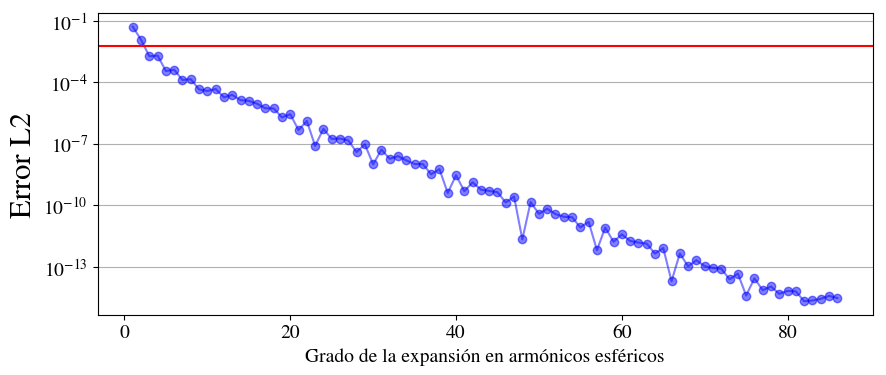

In [10]:
# Grafico del error
pyplot.figure(figsize=(10,4))
ax = pyplot.gca()
pyplot.plot(range(1,n_test+1), errors, 'bo-', alpha=0.5)
pyplot.axhline(err, c='r')

ax.yaxis.grid()
pyplot.xlabel('Grado de la expansión en armónicos esféricos')
pyplot.ylabel('Error L2', fontsize=22)
ax.set_yscale('log')

Como podemos notar, para grados mayores a 2 el error es menor que con la expansión de Taylor. Para los tiempos de ejecución tenemos lo siguiente:

In [11]:
%timeit eval_p(targets, P2M(sources, center), center)

296 µs ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit eval_potential_sp(targets, P2M_sp(sources, center, 5), center)

2.51 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Como notamos, el método utilizando armónicos esféricos es bastante más lento.

In [13]:
times = []

for i in range(25):
    t = %timeit -r 1 -n 1 -o -q eval_potential_sp(targets, P2M_sp(sources, center, i+1), center)
    times.append( t.best )

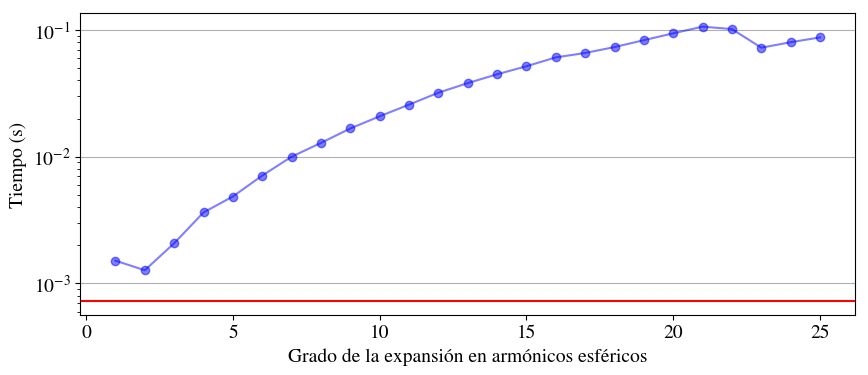

In [14]:
pyplot.figure(figsize=(10,4))
ax = pyplot.gca()
pyplot.plot(range(1, 26), times, 'bo-', alpha=0.5)
tt = %timeit -r 1 -n 1 -o -q  eval_p(targets, P2M(sources, center), center)
pyplot.axhline(tt.best, c='r')

ax.yaxis.grid()
pyplot.xlabel('Grado de la expansión en armónicos esféricos')
pyplot.ylabel('Tiempo (s)')
ax.set_yscale('log')

Y el gráfico de tiempo vs número de particulas queda como sigue:

In [19]:
times2 = []
ns = 25*np.arange(1,20)

for j in ns:
    m = 1./n
    s  = [ Particle(coord, m=m) for coord in numpy.random.random((j, 3)).tolist() ]
    tg = [ Particle(coord, m=m) for coord in (-numpy.random.random((j, 3))).tolist() ]
    t = %timeit -r 1 -n 1 -o -q eval_potential_sp(tg, P2M_sp(s, center, 4), center)
    times2.append( t.best )

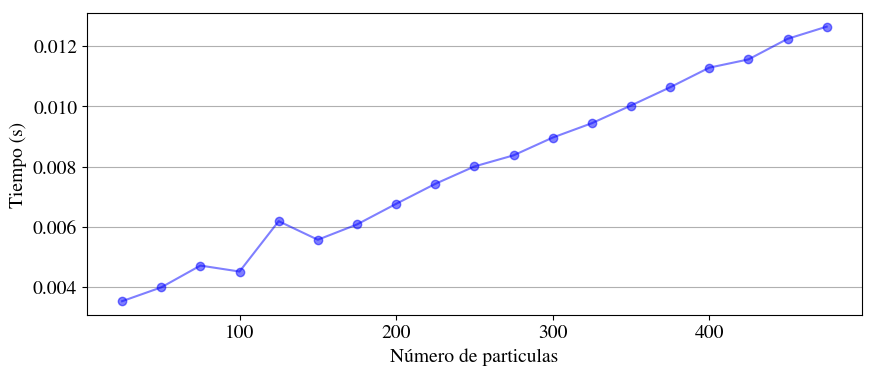

In [20]:
pyplot.figure(figsize=(10,4))
ax = pyplot.gca()
pyplot.plot(ns, times2, 'bo-', alpha=0.5)

ax.yaxis.grid()
pyplot.xlabel('Número de particulas')
pyplot.ylabel('Tiempo (s)')
#ax.set_yscale('log')

Por último, el error relativo por partícula queda como sigue:

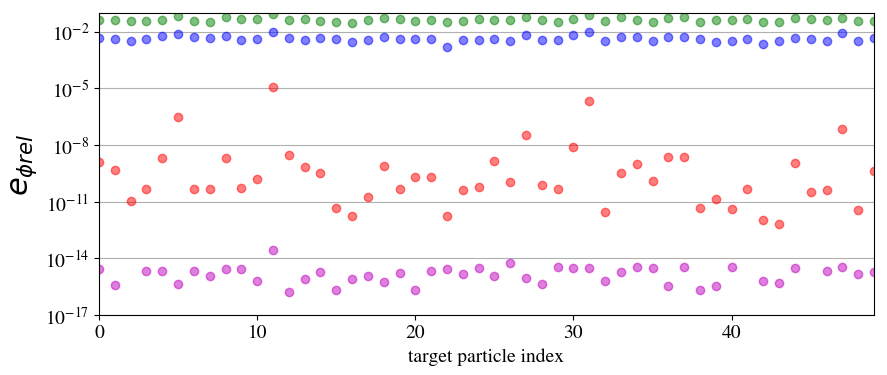

In [21]:
# Error relativo por partícula.
err_rel = abs((phi_multi - phi_direct) / phi_direct)
pyplot.figure(figsize=(10,4))
ax = pyplot.gca()
pyplot.plot(range(n), err_rel, 'bo', alpha=0.5)
pyplot.plot(range(n), abs((phi_sp[0] - phi_direct) / phi_direct), 'go', alpha=0.5)
pyplot.plot(range(n), abs((phi_sp[19] - phi_direct) / phi_direct), 'ro', alpha=0.5)
pyplot.plot(range(n), abs((phi_sp[79] - phi_direct) / phi_direct), 'mo', alpha=0.5)

pyplot.xlim(0,n-1)
pyplot.ylim(1e-17, 1e-1)
ax.yaxis.grid()
pyplot.xlabel('target particle index')
pyplot.ylabel('$e_{\phi rel}$', fontsize=22)
ax.set_yscale('log')

Una de las razones por las cuales el algoritmo que utiliza armónicos esféricos es más lento que el de Taylor es debido a que la estructura de datos guarda cada partícula en coordenadas cartesianas y se calculan sus componentes en esfericas cada vez que es necesario. En un proceso de precalculo se podrían obtener las cordenadas respecto a los centros de cada cruadrante para mejorar la velocidad de la ejecución del algoritmo, pero aumentaría el tiempo de *setup*.

Otra razón para los problemas de desempeño se debe a que los armónicos esféricos son calculados en un bucle. Si este proceso se hiciera vectorialmente podrían mejorar los tiempos de ejecución (aunque no mucho, pues el calculo debe hacerse por componente).

## M2M
Para obtener los multipolos de una caja no final necesiamos la operación M2M.

$$ M^p_{l',m'} = \sum_{l=0}^{l'}\sum_{m=-l}^l T^{MM}_{l'm',lm} M^{h}_{lm} $$
Donde:
$$ \begin{split}
    T^{MM}_{l'm',lm} &= 
        \frac{4\pi (-r_t)^{l'-1}Y^*_{l'-l,m'-m}(\theta_t, \varphi_t)
        a_{l'-l,m'-m}a_{lm}(2l'+1)}{2(l+1)[2(l'-l)+1]a_{l'm'}} \\
    a_{lm} &= \frac{(-1)^{l+m}2(l+1)^{1/2}}{[4m(l+m)!(l-m)!]^{1/2}} \\
    \vec{x}_t &= (r_t, \theta_t, \varphi_t)
\end{split}$$
con $\vec{x}_t$ es el vector entre el centro del padre y el hijo.

In [22]:
from math import factorial
def alm(l,m):
    return ((-1)**(l+m)*2*np.sqrt(l+1))/np.sqrt(4*m*factorial(l+m)*factorial(l-m))

In [23]:
def tlm(l2,m2,l,m, r, th, ph):
    return (
        4*np.pi*((-r)**(l2-1)) * np.conj(sph_harm(m2-m,l2-l,th, ph)) * (2*l2+1) *
        alm(l2-l, m2-m) * alm(l,m) ) / ( 2*(l+1)*(2*(l2-l) + 1) * alm(l2,m2) )

In [27]:
def M2Msp(center, child_centers, child_multipoles, n):
    multipole = np.zeros(n**2, dtype=np.complex_)
    dx = center.x - numpy.array([c.x for c in child_centers])
    dy = center.y - numpy.array([c.y for c in child_centers])
    dz = center.z - numpy.array([c.z for c in child_centers])
    
    r    = np.sqrt(dx**2 + dy**2 + dz**2)
    azim = np.arctan2(dy, dx)
    incl = np.arccos(dz/r)
    
    i = 0
    for l in range(n):
        for m in range(-l,l+1):
            for cm in child_multipoles:
                pass
                #multipole[i] = cm[i] * tlm()
            i += 1
    return multipole

Otra definición de la operación M2M es [1]:
$$\begin{split}
  \Phi(X) &= \sum_{j=0}^{\infty}\sum_{k=-j}^{j}\frac{M_j^k}{r^{j+1}}Y_{jk}(\theta, \phi) \\
  M_j^k &= \sum_{n=0}^{j}\sum_{m=-n}^{n}\frac{O_{j-n}^{k-m}i^{|k|-|m|-|k-m|}
           A_n^mA^{k-m}_{j-n}p^n Y_n^{-m}(\alpha, \beta)}{A_j^k} \\
  A_n^m &= \frac{(-1)^n}{\sqrt{(n-m)!(n+m)!}}
\end{split}$$
Con $X_0=(p,\alpha,\beta)$ como el centro del hijo y $X=(r,\theta,\phi)$ como un punto fuera del cuadrante. $X-X_0 = (r',\theta',\phi')$

$M_j^k$ define un operador lineal que convierte la expansión de multipolos $O_j^k$ a $M_j^k$ ($T_{MM}$).

In [25]:
def TMM(j, k, multipole, r, azim, incl):
    A = lambda n,m: (-1)**n/np.sqrt(factorial(n-m)*factorial(n+m))
    
    #mpl = np.zeros(j**2, dtype=np.complex_)
    r = 0
    for n in range(j):
        for m in range(-n,n+1):
            r += multipole[(j-n)*(j-n+1)+(k-m)] * 1j**(abs(k)-abs(m)-abs(k-m)) \
                 * A(n,m) * A(j-n, k-m) * r * sph_harm(-m,n,azim, incl)
    return r

In [26]:
[l*(l+1)+m for l in range(3) for m in range(-l, l+1)]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

Lamentablemente ninguna de estas implementaciones funciona correctamente, así que para
la ejecución final del treecode calcularemos el multipolo para todos los centros de
expansión directamente

## Treecode
Se modificó el código del tutorial disponible en [2]  (https://github.com/barbagroup/FMM_tutorial) 
los cambios se realizaron en el archivo `treecode2_helper.py`, en particular en las líneas 83, 201-209, 229-244, 254-263, 278 y 378-390

In [34]:
from treecode2_helper import Particle, direct_sum, Cell, build_tree, \
                             get_multipole, l2_err, plot_err, eval_potential

Con las modificaciones hechas se efectua el mismo experimento del paso 6 [2]:

In [29]:
n_crit = 10      # max number of particles in a single cell
theta = 0.5      # a parameter to determine far-field or near-field
n = 1000   # number of particles
particles = [ Particle(m=1.0/n) for i in range(n) ]

In [30]:
# direct summation
direct_sum(particles)

phi_direct = numpy.asarray([particle.phi for particle in particles])
for particle in particles:
    particle.phi = 0.

In [31]:
# build tree
# El último argumento es el grado de descompocisión en armónicos esféricos:
root = Cell(n_crit, 3) 
root.x, root.y, root.z = 0.5, 0.5, 0.5
root.r = 0.5
cells = build_tree(particles, root, n_crit)

In [32]:
# P2M: particle to multipole
leaves = []
get_multipole(particles, 0, cells, leaves, n_crit)

In [35]:
# evaluate potential
eval_potential(particles, cells, n_crit, theta)

phi_tree = numpy.asarray([particle.phi for particle in particles])

In [36]:
l2_err(phi_direct, phi_tree)

L2 Norm error: 0.014099037973120485


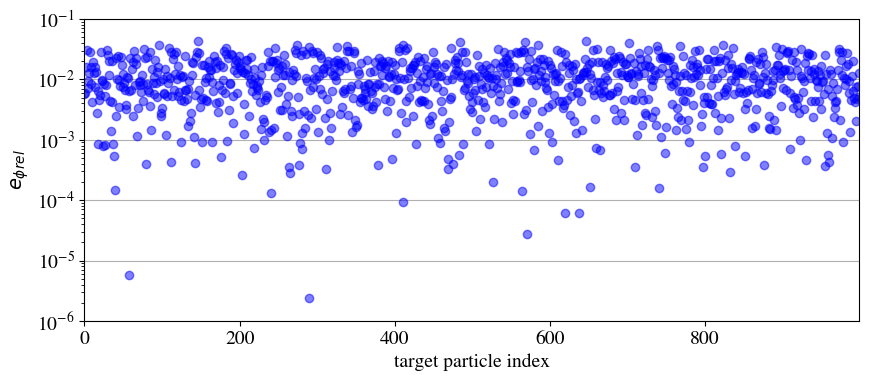

In [37]:
plot_err(phi_direct, phi_tree)

Como podemos notar, el algoritmo funciona, pero el error no es tan bajo como esperabamos.

## Referencias
- [1] Cheng, Hongwei, Leslie Greengard, and Vladimir Rokhlin. "A fast adaptive multipole algorithm in three dimensions." Journal of computational physics 155.2 (1999): 468-498.
- [2] https://github.com/barbagroup/FMM_tutorial

---